<a href="https://colab.research.google.com/github/amitgupta223/Beer_Review_Challenge/blob/main/ColabNotebook_Beer_Review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Mount the Directory

In [197]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Import Necessary Libraries

In [198]:
# Data analysis libraries
import pandas as pd
import numpy as np
import pickle
from datetime import datetime
import re
from wordcloud import WordCloud
from termcolor import cprint
import time

# text analysis

import nltk
nltk.download('vader_lexicon')
nltk.download('punkt')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize
import spacy

sp = spacy.load('en_core_web_sm')
stopwords = sp.Defaults.stop_words

from sklearn.metrics import classification_report as crep

#for loader/show percentage operation done
from tqdm import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings("ignore")
from IPython.display import display
pd.options.display.max_columns = None

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_palette("Set1")

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

# Using plotly + cufflinks in offline mode
import cufflinks
cufflinks.go_offline(connected=True)

# Initiate plotly
init_notebook_mode(connected=True) #do not miss this line

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Load Data

In [199]:
# Load a file from GDrive
df = pd.read_csv('/content/drive/MyDrive/Evolent/BeerDataScienceProject.csv', encoding="ISO-8859-1")
reviews = df.copy()
reviews.head()

beer_ABV  beer_beerId  beer_brewerId               beer_name  \
0       5.0        47986          10325            Sausa Weizen   
1       6.2        48213          10325                Red Moon   
2       6.5        48215          10325  Black Horse Black Beer   
3       5.0        47969          10325              Sausa Pils   
4       7.7        64883           1075           Cauldron DIPA   

                       beer_style  review_appearance  review_palette  \
0                      Hefeweizen                2.5             2.0   
1              English Strong Ale                3.0             2.5   
2          Foreign / Export Stout                3.0             2.5   
3                 German Pilsener                3.5             3.0   
4  American Double / Imperial IPA                4.0             4.5   

   review_overall  review_taste review_profileName  review_aroma  \
0             1.5           1.5            stcules           1.5   
1             3.0           3.0            stcules           3.0   
2             3.0           3.0            stcules           3.0   
3             3.0           2.5            stcules           3.0   
4             4.0           4.0     johnmichaelsen           4.5   

                                         review_text  review_time  
0  A lot of foam. But a lot. In the smell some ba...   1234817823  
1  Dark red color, light beige foam, average. In ...   1235915097  
2  Almost totally black. Beige foam, quite compac...   1235916604  
3  Golden yellow color. White, compact foam, quit...   1234725145  
4  According to the website, the style for the Ca...   1293735206

In [200]:
reviews.shape

(528870, 13)

#Exploratory Analysis

##Types of Data

In [201]:
# Convert 'object' to 'category' 
reviews[reviews.select_dtypes(['object']).columns] = reviews.select_dtypes(['object']).\
                                                         apply(lambda x: x.astype('category'))
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 528870 entries, 0 to 528869
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   beer_ABV            508590 non-null  float64 
 1   beer_beerId         528870 non-null  int64   
 2   beer_brewerId       528870 non-null  int64   
 3   beer_name           528870 non-null  category
 4   beer_style          528870 non-null  category
 5   review_appearance   528870 non-null  float64 
 6   review_palette      528870 non-null  float64 
 7   review_overall      528870 non-null  float64 
 8   review_taste        528870 non-null  float64 
 9   review_profileName  528755 non-null  category
 10  review_aroma        528870 non-null  float64 
 11  review_text         528751 non-null  category
 12  review_time         528870 non-null  int64   
dtypes: category(4), float64(6), int64(3)
memory usage: 62.3 MB


## Missing Data

###Count Null Values

In [202]:
# Check for null values
print(reviews.isnull().sum())

beer_ABV              20280
beer_beerId               0
beer_brewerId             0
beer_name                 0
beer_style                0
review_appearance         0
review_palette            0
review_overall            0
review_taste              0
review_profileName      115
review_aroma              0
review_text             119
review_time               0
dtype: int64


In [203]:
# Percent of data missing `beer_abv` values
print("Percent Null Values of `beer_ABV` column:", round(20280 / 528870 * 100, 2),"%")

Percent Null Values of `beer_ABV` column: 3.83 %


###Drop Null Values

In [204]:
# Drop null row values
reviews = reviews.dropna()
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 508358 entries, 0 to 528796
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   beer_ABV            508358 non-null  float64 
 1   beer_beerId         508358 non-null  int64   
 2   beer_brewerId       508358 non-null  int64   
 3   beer_name           508358 non-null  category
 4   beer_style          508358 non-null  category
 5   review_appearance   508358 non-null  float64 
 6   review_palette      508358 non-null  float64 
 7   review_overall      508358 non-null  float64 
 8   review_taste        508358 non-null  float64 
 9   review_profileName  508358 non-null  category
 10  review_aroma        508358 non-null  float64 
 11  review_text         508358 non-null  category
 12  review_time         508358 non-null  int64   
dtypes: category(4), float64(6), int64(3)
memory usage: 64.6 MB


In [205]:
# Check for null values
print(reviews.isnull().sum())

beer_ABV              0
beer_beerId           0
beer_brewerId         0
beer_name             0
beer_style            0
review_appearance     0
review_palette        0
review_overall        0
review_taste          0
review_profileName    0
review_aroma          0
review_text           0
review_time           0
dtype: int64


##Duplicate Data

If a user has rated the same beer more than once, then only keep their highest rating.

In [206]:
# Sort by user overall rating first
reviews = reviews.sort_values('review_overall', ascending=False)

# Keep the highest rating from each user and drop the rest 
reviews = reviews.drop_duplicates(subset= ['review_profileName','beer_name'], keep='first')

# Peep structure
reviews.info()

# # Percent of data that are duplicates
print("Percent of Duplicate Values:", round((508358 - 502769)/ 508358* 100, 2),"%")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 502769 entries, 492945 to 39638
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   beer_ABV            502769 non-null  float64 
 1   beer_beerId         502769 non-null  int64   
 2   beer_brewerId       502769 non-null  int64   
 3   beer_name           502769 non-null  category
 4   beer_style          502769 non-null  category
 5   review_appearance   502769 non-null  float64 
 6   review_palette      502769 non-null  float64 
 7   review_overall      502769 non-null  float64 
 8   review_taste        502769 non-null  float64 
 9   review_profileName  502769 non-null  category
 10  review_aroma        502769 non-null  float64 
 11  review_text         502769 non-null  category
 12  review_time         502769 non-null  int64   
dtypes: category(4), float64(6), int64(3)
memory usage: 64.2 MB
Percent of Duplicate Values: 1.1 %


##Overview of Numeric Features

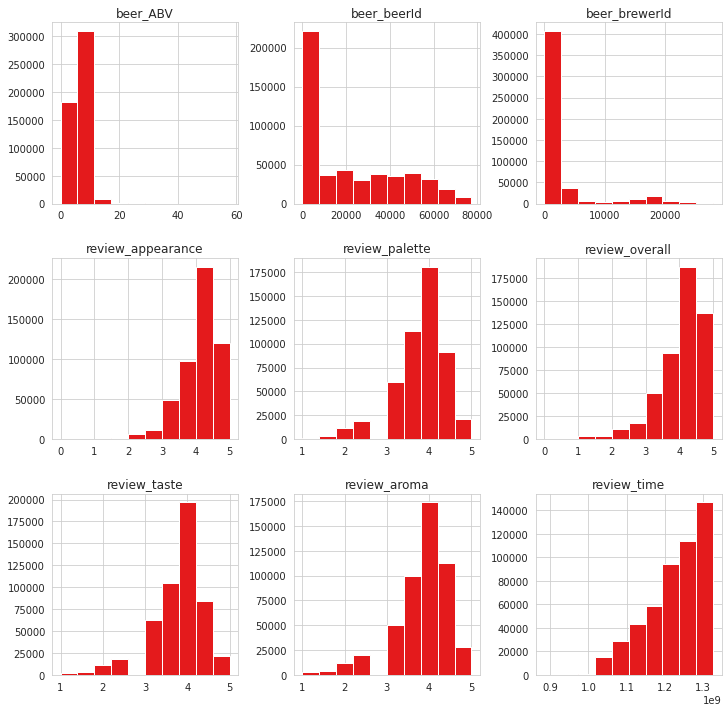

In [207]:
# Histogram of all numeric features
reviews.hist(figsize=(12,12))
plt.show()

|Numeric Variable| Distribution|Interpretation|
|---|---|---|
|`beer_ABV`| Skewed right | Most beers are less than 20% ABV|
|`beer_beerid`| Skewed right | Lower IDs have more reviews than higher IDs|
|`beer_breweryld`| Skewed right| Lower IDs have more reviews than higher IDs|
|`review_appearance`|Skewed left| Most beers rated 4 and higher|
|`review_aroma`| Normal | Most beers rated between 3 and 4|
|`review_overall`|Skewed left| Most beers rated 4 and higher|
|`review_palette`|Normal| Most beers rated between 3 and 4|
|`review_taste`|Normal| Most beers rated between 3.5 and 4.5 |
|`review_time`|Skewed left| Num of beers rated vs time suggests linearity|

> *Also note the existence of ratings which have a value of 0 in the* `review_overall` *&* `review_appearance` *columns.*

##Ratings of 0

Since ratings are on a scale of 1-5, any values in review variables that are less than 1 are not suitable for analysis. 

In [208]:
# Review scores of >= 1
reviews = reviews[(reviews['review_overall'] >= 1) | \
        (reviews['review_appearance'] >= 1)]

# Check it out
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 502766 entries, 492945 to 188052
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   beer_ABV            502766 non-null  float64 
 1   beer_beerId         502766 non-null  int64   
 2   beer_brewerId       502766 non-null  int64   
 3   beer_name           502766 non-null  category
 4   beer_style          502766 non-null  category
 5   review_appearance   502766 non-null  float64 
 6   review_palette      502766 non-null  float64 
 7   review_overall      502766 non-null  float64 
 8   review_taste        502766 non-null  float64 
 9   review_profileName  502766 non-null  category
 10  review_aroma        502766 non-null  float64 
 11  review_text         502766 non-null  category
 12  review_time         502766 non-null  int64   
dtypes: category(4), float64(6), int64(3)
memory usage: 64.2 MB


> *There were only eight reviews with ratings of less than 1 here which is basically negligible. However, it's always a good idea to check for numbers which don't make sense in your dataset.*

# Remove Strings

In [209]:
# Split after / & keep only first string
reviews['beer_style'] = reviews['beer_style'].str.split(' / ').str[0]

#Questions

### Question 1 : Rank top 3 Breweries which produce the strongest beers?

In [210]:
# Pivot table with Beer Brewer Id
top_3_rec = reviews[['beer_brewerId','beer_ABV']]\
    .pivot_table(index="beer_brewerId", aggfunc=("count",'mean','median'))\
    .dropna()

# Rename columns and flatten pivot table
top_3_rec.columns = top_3_rec.columns.to_series().str.join('_')
top_3_rec.reset_index(inplace=False)

# Filter for Top 3 Breweries
top_3_rec = top_3_rec.query('beer_ABV_count >= 1')\
  .sort_values('beer_ABV_mean', ascending=False)\
  .head(3)

# Check it out
top_3_rec

beer_ABV_count  beer_ABV_mean  beer_ABV_median
beer_brewerId                                                
6513                       34      19.228824             13.0
736                        18      13.750000             14.0
24215                       3      12.466667             11.0

###Top 3 Breweries by Highest Mean ABV

In [211]:
# Use only unique beers and breweries for aggregate stats
abv = reviews[['beer_name','beer_brewerId','beer_ABV']]\
    .drop_duplicates(['beer_name','beer_brewerId'])\
    .pivot_table(index="beer_brewerId", aggfunc=("count",'mean','median'))

# Adjust column names
abv.columns = abv.columns.to_series().str.join('_')

# Reset index
abv.reset_index(inplace=True)

# Rename column
abv.rename(columns={'beer_ABV_count':'beer_count'}, inplace=True)

# Filter for breweries with at least 4 unique beers
abv_filtered_mean = abv.query('beer_count >= 4')\
    .sort_values('beer_ABV_mean', ascending=False)\
    .head(3)\
    .sort_values('beer_ABV_mean', ascending=True)

# Plot it
p1 = [go.Bar(x = abv_filtered_mean['beer_ABV_mean'] / 100,
             y = abv_filtered_mean['beer_brewerId'],
             text=abv_filtered_mean['beer_ABV_mean'].round(1),
             hoverinfo='x',
             textposition = 'inside',
             orientation = 'h',
             opacity=0.7, 
             marker=dict(
                color='rgb(1, 87, 155)'))]

# Pieces of Flair
layout = go.Layout(title='Top 3 Breweries by Highest Mean ABV',
                   xaxis=dict(title="Mean ABV",
                              tickformat='%',
                              hoverformat = '.2%'),
                   margin = dict(l = 230),
                   font=dict(family='Courier New, monospace',
                            color='dark gray'))

fig = go.Figure(data=p1, layout=layout)

# Plot it
fig.show(renderer="colab")

###Answer 1: From the above Analysis, we can see that the Top 3 breweries which beer_brewerIds are		
### 6513
### 736
### 24215

### Question 2 : Which year did beers enjoy the highest ratings ? 

In [212]:
review_Data = reviews[['beer_beerId','beer_name','review_overall','review_time']]

In [213]:
review_Data['review_year'] = review_Data.apply(lambda row: datetime.utcfromtimestamp(row.review_time).strftime("%Y"), axis=1)

In [214]:
review_Data = review_Data.reset_index(drop=True)

In [215]:
review_Data.head(5)

beer_beerId                     beer_name  review_overall  review_time  \
0         1339         Hazelnut Brown Nectar             5.0   1221003321   
1          689     Red Stripe Jamaican Lager             5.0   1129192511   
2        15881          Tröegs Nugget Nectar             5.0   1235006981   
3          571  Samuel Smith's Oatmeal Stout             5.0   1203476701   
4          689     Red Stripe Jamaican Lager             5.0   1135296352   

  review_year  
0        2008  
1        2005  
2        2009  
3        2008  
4        2005

In [216]:
aggrReview_Data = review_Data.groupby(['review_year'], as_index=False)['review_overall'].agg('mean')

In [217]:
aggrReview_Data.head(5)

review_year  review_overall
0        1998        4.045455
1        1999        4.000000
2        2000        4.241379
3        2001        3.963687
4        2002        3.822886

In [218]:
# sorting the dataframe in desceding order

aggrReview_Data = aggrReview_Data.sort_values(by=['review_overall'], ascending=False)

In [219]:
aggrReview_Data.head(5)

review_year  review_overall
2         2000        4.241379
0         1998        4.045455
1         1999        4.000000
3         2001        3.963687
12        2010        3.870411

In [220]:
# Plot it
p1 = [go.Bar(x = aggrReview_Data['review_overall'],
             y = aggrReview_Data['review_year'],
             text=aggrReview_Data['review_overall'],
             hoverinfo='x',
             textposition = 'inside',
             orientation = 'h',
             opacity=0.7, 
             marker=dict(
                color='rgb(1, 87, 155)'))]

# Pieces of Flair
layout = go.Layout(title='Overall reveiw corresponding Years',
                   xaxis=dict(title="review_overall",
                              hoverformat = '.2%'),
                   margin = dict(l = 230),
                   font=dict(family='Courier New, monospace',
                            color='dark gray'))

fig = go.Figure(data=p1, layout=layout)

# Plot it
fig.show(renderer="colab")

#### Answer 2 : From above bar plot we can see that at a year '2000' beer enjoys higest overall ratings of "4.241379"

##Question 3: Based on the User's ratings Which factors are important among taste, aroma, appearance and palette?

In [221]:
#Heatmap: Plotly

# List of numeric factors to include
factors = ["review_appearance","review_aroma","review_palette","review_taste", "review_overall"]
# Create a correlation matrix 
corr_metrics = reviews[factors].corr()

heat_map_plotly = ff.create_annotated_heatmap(
    z=corr_metrics.values,
    x=list(corr_metrics.columns),
    y=list(corr_metrics.index),
    annotation_text=corr_metrics.round(2).values,
    showscale=True,
    colorscale='Portland',
    font_colors=['white','white'])

layout = go.Layout(title="Correlation Heatmap",
                   margin = dict(l = 330))

fig = go.Figure(data=heat_map_plotly, layout=layout)
fig.show(renderer="colab")

In [222]:
# Bar Chart: Plotly
# Correlation with target review_overall
factor_corr = corr_metrics[['review_overall']]\
    .drop(['review_overall'])\
    .reset_index()\
    .sort_values('review_overall', ascending=True)

# Plot it with Plotly
p4 = [go.Bar(x = factor_corr['review_overall'],
            y = factor_corr['index'],
            hoverinfo='x',
            text=factor_corr['review_overall'].round(2),
            textposition = 'inside',
            orientation = 'h',
            opacity=0.7, 
            marker=dict(
                color='rgb(1, 87, 155)'))]

# Pieces of Flair
layout = go.Layout(title='Correlation with Target: review_overall',
                   xaxis=dict(title="Correlation",
                              hoverformat = '.2f'),
                   margin = dict(l = 130),
                   font=dict(family='Courier New, monospace',
                            color='dark gray'))

fig = go.Figure(data=p4, layout=layout)

# Plot it
fig.show(renderer="colab")

###Answers 3: From above visualizations we can see that which factors are important among taste, aroma, appearance and palette

## Question 4: If you had to pick 3 beers to recommend using only this data, which would you pick?

###Simplest Recommendation

If I were to recommend 3 beers to somebody who is new to beer (i.e. does not have a style preference), then I'd first narrow down to the most popular beers and subsequently find the highest rated beers amongst that subset. 

Idea behind this to findout a widely-known beer with a high rating increases the chance that your recommendations will be taken more favorably from your audience as opposed to you offering an obscure beer with a high rating. Most people tend to like things that other people like. 

In [223]:
# Pivot table with overall rating
top_3_rec = reviews[['beer_name','review_overall']]\
    .pivot_table(index="beer_name", aggfunc=("count",'mean','median'))\
    .dropna()

# Rename columns and flatten pivot table
top_3_rec.columns = top_3_rec.columns.to_series().str.join('_')
top_3_rec.reset_index(inplace=True)

# Filter for highest rated beers
top_3_rec = top_3_rec.query('review_overall_count >= 1000')\
  .sort_values('review_overall_mean', ascending=False)\
  .head(3)

# Check it out
top_3_rec

beer_name  review_overall_count  \
4661   Founders KBS (Kentucky Breakfast Stout)                  1873   
12865                     Tröegs Nugget Nectar                  1878   
4614                  Founders Breakfast Stout                  2443   

       review_overall_mean  review_overall_median  
4661              4.402029                    4.5  
12865             4.394835                    4.5  
4614              4.359394                    4.5

In [224]:
# Plot it
p1 = [go.Bar(x = top_3_rec['review_overall_count'],
             y = top_3_rec['beer_name'],
             text=top_3_rec['review_overall_count'],
             hoverinfo='x',
             textposition = 'inside',
             orientation = 'h',
             opacity=0.7, 
             marker=dict(
                color='rgb(1, 87, 155)'))]

# Pieces of Flair
layout = go.Layout(title='Top 3 Recommended Beer',
                   xaxis=dict(title="review_overall_count",
                              hoverformat = '.2&'),
                   margin = dict(l = 230),
                   font=dict(family='Courier New, monospace',
                            color='dark gray'))

fig = go.Figure(data=p1, layout=layout)

# Plot it
fig.show(renderer="colab")

###Answer 4: Top 3 recommended Beer are 
###Founders KBS (Kentucky Breakfast Stout)
###Tröegs Nugget Nectar
###Founders Breakfast Stout	

### Question 5 : Which Beer style seems to be the favorite based on Reviews written by users?

In [225]:
reviews.columns

Index(['beer_ABV', 'beer_beerId', 'beer_brewerId', 'beer_name', 'beer_style',
       'review_appearance', 'review_palette', 'review_overall', 'review_taste',
       'review_profileName', 'review_aroma', 'review_text', 'review_time'],
      dtype='object')

In [226]:
# Considering only relevant columns

reviewTextData = reviews[['beer_beerId','beer_name','beer_ABV','beer_style','review_overall','review_text']]

In [227]:
# lets consider the higher reviews only to calculate the polarity score of review_text and compare it with overall review

reviewTextData = reviewTextData.loc[reviewTextData['review_overall'] >= 4]

In [228]:
#Resetting Index

reviewTextData.reset_index(drop=True,inplace=True)

In [229]:
reviewTextData.head(4)

beer_beerId                     beer_name  beer_ABV  \
0         1339         Hazelnut Brown Nectar       6.2   
1          689     Red Stripe Jamaican Lager       4.7   
2        15881          Tröegs Nugget Nectar       7.5   
3          571  Samuel Smith's Oatmeal Stout       5.0   

               beer_style  review_overall  \
0      American Brown Ale             5.0   
1  American Adjunct Lager             5.0   
2          American Amber             5.0   
3           Oatmeal Stout             5.0   

                                         review_text  
0  Served at ~15C. Gorgeous pour. Nut brown, slig...  
1  This beer is tops. The crisp, yet smooth taste...  
2  Thanks to mikereaser for sending this in a tra...  
3  this beer is a must try. very drinkable and ve...

### Printing some reviews to observe the text

In [230]:
reviewTextData.review_text[0]

"Served at ~15C. Gorgeous pour. Nut brown, slightly reddish with a voluminous tan head that leaves lots of lace. Very clear. Smells odd - perhaps that's the hazelnut, but to me it just smells cardboardy and stale. There's biscuit, bready yeast, and roasty notes as well with a nice malty aroma holding things together. There's a light fruity hops note as well, very understated. Mouthfeel is very very good. Low-ish carbonation, no acrid zing. There's a definite nuttiness to it, nicely accented by sweet dark malt and baked bread flavours and some medium roast bitterness. Light floral hops in the background. Very very mellow, almost no bitterness. This stuff is dangerously smooth and easy to drink."

In [231]:
reviewTextData.review_text[500]

'Enjoyed at the out of the way Bavarian place outside Central Munich, just a lovely memory. Reviewing from notes. Poured a clear light gold, fluffy white head. Grassy, maybe light citrus fruits. Hopes are understated and well integrated. So crisp, exactly what I want in the style. Just lightly fruity, wonderfully dry, grassy, tight, and crisp. This was more like a Czech style pils to me. Awesome.'

###Text Preprocessing

In [232]:
# # Remove stop words
# def remove_stopwords(text):
#     text = ' '.join([word for word in text.split() if word not in (stopwords.words('english'))])
#     return text

# Remove url  
def remove_url(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

# Remove punct
def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Remove html 
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

# Remove @username
def remove_username(text):
    return re.sub('@[^\s]+','',text)

# Remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


# Decontraction text
def decontraction(text):
    text = re.sub(r"won\'t", " will not", text)
    text = re.sub(r"won\'t've", " will not have", text)
    text = re.sub(r"can\'t", " can not", text)
    text = re.sub(r"don\'t", " do not", text)
    text = re.sub(r"can\'t've", " can not have", text)
    text = re.sub(r"ma\'am", " madam", text)
    text = re.sub(r"let\'s", " let us", text)
    text = re.sub(r"ain\'t", " am not", text)
    text = re.sub(r"shan\'t", " shall not", text)
    text = re.sub(r"sha\n't", " shall not", text)
    text = re.sub(r"o\'clock", " of the clock", text)
    text = re.sub(r"y\'all", " you all", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"n\'t've", " not have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d've", " would have", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll've", " will have", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'re", " are", text)
    return text  

# Seperate alphanumeric
def seperate_alphanumeric(text):
    words = text
    words = re.findall(r"[^\W\d_]+|\d+", words)
    return " ".join(words)

def cont_rep_char(text):
    tchr = text.group(0) 
    
    if len(tchr) > 1:
        return tchr[0:2] 

def unique_char(rep, text):
    substitute = re.sub(r'(\w)\1+', rep, text)
    return substitute

def char(text):
    substitute = re.sub(r'[^a-zA-Z]',' ',text)
    return substitute

# combaine negative reason with  tweet (if exsist)
# df['final_text'] = df['negativereason'].fillna('') + ' ' + df['text'] 
reviewTextData['preprocessed_text'] = reviewTextData['review_text'] 


# Apply functions on review text
reviewTextData['preprocessed_text'] = reviewTextData['preprocessed_text'].apply(lambda x : remove_username(x))
reviewTextData['preprocessed_text'] = reviewTextData['preprocessed_text'].apply(lambda x : remove_url(x))
reviewTextData['preprocessed_text'] = reviewTextData['preprocessed_text'].apply(lambda x : remove_emoji(x))
reviewTextData['preprocessed_text'] = reviewTextData['preprocessed_text'].apply(lambda x : decontraction(x))
reviewTextData['preprocessed_text'] = reviewTextData['preprocessed_text'].apply(lambda x : seperate_alphanumeric(x))
reviewTextData['preprocessed_text'] = reviewTextData['preprocessed_text'].apply(lambda x : unique_char(cont_rep_char,x))
reviewTextData['preprocessed_text'] = reviewTextData['preprocessed_text'].apply(lambda x : char(x))
reviewTextData['preprocessed_text'] = reviewTextData['preprocessed_text'].apply(lambda x : x.lower())
# reviewTextData['final_text'] = reviewTextData['final_text'].apply(lambda x : remove_stopwords(x))

In [233]:
reviewTextData.head(3)

beer_beerId                  beer_name  beer_ABV              beer_style  \
0         1339      Hazelnut Brown Nectar       6.2      American Brown Ale   
1          689  Red Stripe Jamaican Lager       4.7  American Adjunct Lager   
2        15881       Tröegs Nugget Nectar       7.5          American Amber   

   review_overall                                        review_text  \
0             5.0  Served at ~15C. Gorgeous pour. Nut brown, slig...   
1             5.0  This beer is tops. The crisp, yet smooth taste...   
2             5.0  Thanks to mikereaser for sending this in a tra...   

                                   preprocessed_text  
0  served at    c gorgeous pour nut brown slightl...  
1  this beer is tops the crisp yet smooth taste l...  
2  thanks to mikereaser for sending this in a tra...

###Sentiment Analysis: Text Blob Method-1

In [234]:
from textblob import TextBlob

In [235]:
texts = reviewTextData['preprocessed_text'].tolist()
textblob_score = []
textblob_tag = []
for text in texts:
    doc_current = TextBlob(text)
    score = doc_current.polarity
    textblob_score.append(score)
    if score > 0:
        textblob_tag.append('positive')
    elif score<0:
        textblob_tag.append('negative')
    else:
        textblob_tag.append('neutral')
reviewTextData['textblob_score'] = textblob_score
reviewTextData['textblob_sentiment_tag'] = textblob_tag

In [236]:
reviewTextData[['beer_beerId','beer_name','beer_ABV','beer_style','review_overall','review_text','preprocessed_text','textblob_score','textblob_sentiment_tag']].tail(5)

beer_beerId                      beer_name  beer_ABV  \
324332         1904  Sierra Nevada Celebration Ale       6.8   
324333         1914     1554 Enlightened Black Ale       5.6   
324334         1914     1554 Enlightened Black Ale       5.6   
324335        27857                  Old Leghumper       6.7   
324336        35732   Green Flash Hop Head Red Ale       7.0   

              beer_style  review_overall  \
324332      American IPA             4.0   
324333  Belgian Dark Ale             4.0   
324334  Belgian Dark Ale             4.0   
324335   American Porter             4.0   
324336    American Amber             4.0   

                                              review_text  \
324332  First of all I was not overly impressed with t...   
324333  Poured a deep brown with bronze highlights, wi...   
324334  A: Dark red, thou you cant tell that unless it...   
324335  Pours a deep, dark brown with ruby and copper ...   
324336  Bitter start with a crisp finish. Just as you'...   

                                        preprocessed_text  textblob_score  \
324332  first of all i was not overly impressed with t...        0.207143   
324333  poured a deep brown with bronze highlights wit...        0.190000   
324334  a dark red thou you cant tell that unless it i...       -0.053829   
324335  pours a deep dark brown with ruby and copper h...        0.246154   
324336  bitter start with a crisp finish just as you a...        0.118056   

       textblob_sentiment_tag  
324332               positive  
324333               positive  
324334               negative  
324335               positive  
324336               positive

In [237]:
# Groupping by the 'beer_style'and calculate mean textblob score.

reviewTextDataGroupped = reviewTextData.groupby('beer_style')['textblob_score'].mean()

In [238]:
reviewTextDataGroupped.sort_values(ascending=False)[0:5]

beer_style
Vienna Lager      0.258626
Dortmunder        0.256999
Czech Pilsener    0.238833
Märzen            0.234175
Pumpkin Ale       0.230154
Name: textblob_score, dtype: float64

In [239]:
# Obsering the top 'textblob_score' and 'beer_style' associated with it.
reviewTextData.loc[reviewTextData['beer_style'] == 'Vienna Lager']

beer_beerId               beer_name  beer_ABV    beer_style  \
6782          47292     Dynamo Copper Lager       5.8  Vienna Lager   
6784          47292     Dynamo Copper Lager       5.8  Vienna Lager   
6837          47292     Dynamo Copper Lager       5.8  Vienna Lager   
6909            229  Great Lakes Eliot Ness       6.2  Vienna Lager   
6910            229  Great Lakes Eliot Ness       6.2  Vienna Lager   
...             ...                     ...       ...           ...   
314684        53124            Vienna Lager       4.2  Vienna Lager   
318764        59991            Boston Lager       6.2  Vienna Lager   
321276        34417      Vienna Style Lager       4.0  Vienna Lager   
321300        34417      Vienna Style Lager       4.0  Vienna Lager   
321302        34417      Vienna Style Lager       4.0  Vienna Lager   

        review_overall                                        review_text  \
6782               5.0  This might just be my all-time favorite beer. ...   
6784               5.0  Pouring a gorgeous, dirty orange into my tulip...   
6837               5.0  Whoa. A massive amount of foam (about half a h...   
6909               5.0  Looks acsolutely stunning in a glass. It's har...   
6910               5.0  Pours a transparent auburn color with minimal ...   
...                ...                                                ...   
314684             4.0  I sampled this at C'est What but then went bac...   
318764             4.0  Served in a shaker pint glass. A Boston lager ...   
321276             4.0  This brew poured a brown color, not too dark a...   
321300             4.0  Had at the brewpub in Salt Lake City. Beer was...   
321302             4.0  Pours copper amber with a thin white head that...   

                                        preprocessed_text  textblob_score  \
6782    this might just be my all time favorite beer i...        0.478571   
6784    pouring a gorgeous dirty orange into my tulip ...        0.183125   
6837    whoa a massive amount of foam about half a hal...       -0.028267   
6909    looks acsolutely stunning in a glass it is har...        0.414373   
6910    pours a transparent auburn color with minimal ...        0.130111   
...                                                   ...             ...   
314684  i sampled this at c est what but then went bac...        0.295625   
318764  served in a shaker pint glass a boston lager n...        0.118095   
321276  this brew poured a brown color not too dark an...        0.311458   
321300  had at the brewpub in salt lake city beer was ...        0.290000   
321302  pours copper amber with a thin white head that...        0.108974   

       textblob_sentiment_tag  
6782                 positive  
6784                 positive  
6837                 negative  
6909                 positive  
6910                 positive  
...                       ...  
314684               positive  
318764               positive  
321276               positive  
321300               positive  
321302               positive  

[2954 rows x 9 columns]

###Answer 5: By doing above analysis we can say that the beer style "Vienna Lager" is quite most famous.

### Question 6: How does written review compare to overall review score for the beer style?

###Sentiment Analysis Text Blob Method-2

In [240]:
#Let us try using textblob polarity score
df = pd.read_csv('/content/drive/MyDrive/Evolent/BeerDataScienceProject.csv', encoding="ISO-8859-1")

In [241]:
df.columns

Index(['beer_ABV', 'beer_beerId', 'beer_brewerId', 'beer_name', 'beer_style',
       'review_appearance', 'review_palette', 'review_overall', 'review_taste',
       'review_profileName', 'review_aroma', 'review_text', 'review_time'],
      dtype='object')

In [242]:
df = df[['beer_beerId','beer_name', 'beer_style','review_overall','review_text']]
df["word_count"] = df['review_text'].str.split().str.len()
df['count'] = 1
df = df[df["word_count"] > 30]
df = df.groupby("review_overall").sample(n=300, random_state=1, replace=True).reset_index()
sia = SentimentIntensityAnalyzer()
start = time.time()
df["sentiment_score"] = df["review_text"].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
end = time.time()
print(end - start)
df["sentiment"] = np.select([df["sentiment_score"] < 0, df["sentiment_score"] == 0, df["sentiment_score"] > 0],
                           ['neg', 'neu', 'pos'])


2.240020513534546


In [243]:
df.head(3)

index  beer_beerId          beer_name       beer_style  review_overall  \
0  39617         3804  Latter Days Stout  Irish Dry Stout             0.0   
1  39601         3806           Pub Pils   Czech Pilsener             0.0   
2  39601         3806           Pub Pils   Czech Pilsener             0.0   

                                         review_text  word_count  count  \
0  This beer presents with a heavy smoky roast ar...        53.0      1   
1  This is one of the most commercial tasting mic...        45.0      1   
2  This is one of the most commercial tasting mic...        45.0      1   

   sentiment_score sentiment  
0        -0.181728       neg  
1         0.142857       pos  
2         0.142857       pos

###Evaluation Metrics

In [244]:
df_grouped_1 = df.groupby(["review_overall", "sentiment"]).sum()
df_grouped_1

index  beer_beerId  word_count  count  \
review_overall sentiment                                             
0.0            neg         7449907       715698      8508.0    188   
               pos         4435312       426272      5040.0    112   
1.0            neg        36414912      2809457     15541.0    135   
               pos        43230276      3373007     22299.0    165   
1.5            neg        30141695      2495380     13438.0    117   
               pos        48736126      3715845     23906.0    183   
2.0            neg        17593416      1219864      6330.0     66   
               neu         1139755       135750       167.0      3   
               pos        65251894      4568870     29229.0    231   
2.5            neg        14613414      1357883      5290.0     55   
               pos        65001074      4682509     30330.0    245   
3.0            neg         6971887       490701      2182.0     24   
               pos        78317024      5508119     32189.0    276   
3.5            neg         1871135       267276      1200.0     12   
               pos        77041056      6635777     35499.0    288   
4.0            neg         2425538       261442       830.0      8   
               pos        76179794      6863068     34031.0    292   
4.5            neg         1638428       135906       348.0      4   
               pos        78522649      6223526     39440.0    296   
5.0            neg         1866625         3549       477.0      5   
               pos        79983525      5207385     41624.0    295   

                          sentiment_score  
review_overall sentiment                   
0.0            neg             -19.295988  
               pos              16.000000  
1.0            neg             -15.564026  
               pos              18.517497  
1.5            neg             -12.805257  
               pos              21.418847  
2.0            neg              -5.206573  
               neu               0.000000  
               pos              27.452363  
2.5            neg              -4.197090  
               pos              32.428331  
3.0            neg              -1.689509  
               pos              40.898200  
3.5            neg              -0.448281  
               pos              49.873641  
4.0            neg              -0.274594  
               pos              59.143999  
4.5            neg              -0.112853  
               pos              65.417456  
5.0            neg              -0.189701  
               pos              69.665076

In [245]:
def evaluate_results(df):
    if (5, "pos") in df.index:
        true_positives = df.loc[(5, "pos")]["count"]
    else:
        true_positives = 0
    if (5, "neg") in df.index:
        false_negatives = df.loc[(5, "neg")]["count"]
    else:
        false_negatives = 0
    if (1, "pos") in df.index:
        false_positives = df.loc[(1, "pos")]["count"]
    else:
        false_positives = 0
    if (5, "neg") in df.index:
        true_negatives = df.loc[(1, "neg")]["count"]
    else:
        true_negatives = 0
    accuracy = (true_positives + true_negatives) / (true_positives + false_positives + false_negatives + true_negatives)
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    specificity = true_negatives / (true_negatives + false_positives)
    f1 = 2 * (precision * recall) / (precision + recall)
    print("Accuracy: " + str(accuracy * 100))
    print("Precision: " + str(precision * 100))
    print("Specificity: " + str(specificity * 100))
    print("F1: " + str(f1 * 100))

In [246]:
evaluate_results(df_grouped_1)

Accuracy: 71.66666666666667
Precision: 64.13043478260869
Specificity: 45.0
F1: 77.63157894736841


###Text Visualization

In [247]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=3200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

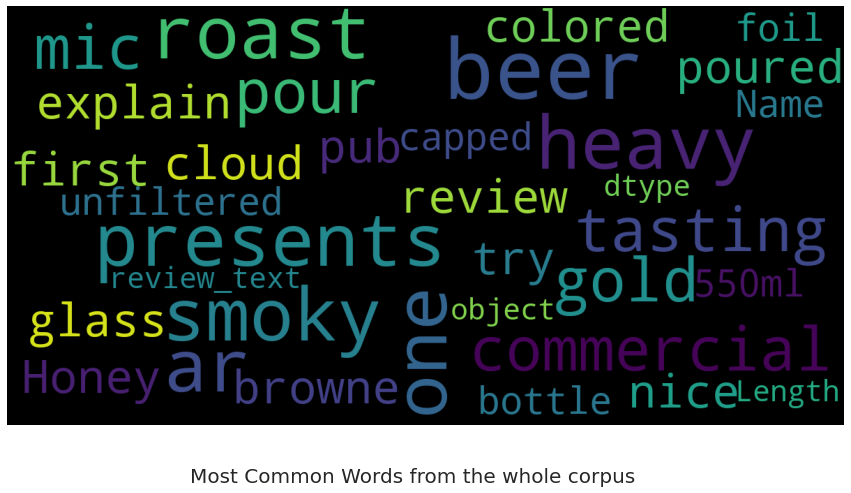

In [248]:
show_wordcloud(df['review_text'],'Most Common Words from the whole corpus')

In [249]:
positive=df[df['sentiment']=='pos'].review_text
negative=df[df['sentiment']=='neg'].review_text
neutral=df[df['sentiment']=='neu'].review_text

Text(0.5, 1.0, 'Positive Sentiment')

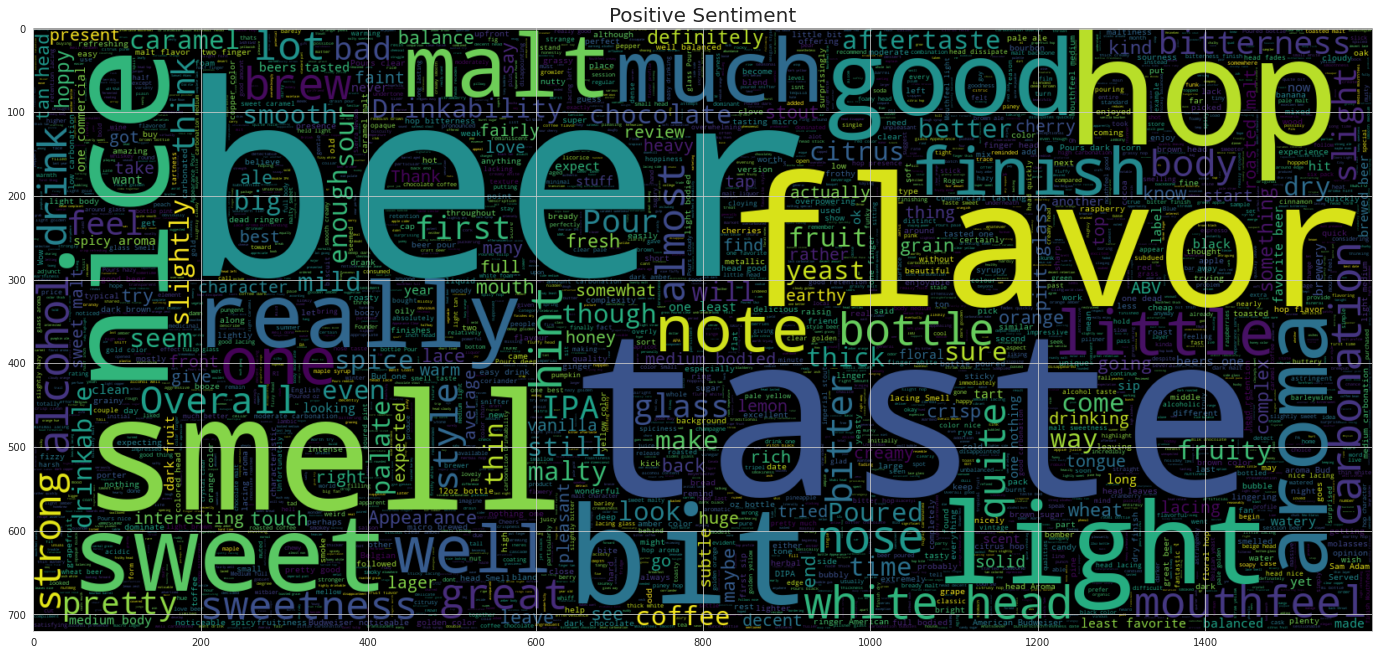

In [250]:
plt.figure(figsize=(24,20))
world_cloud_postive=WordCloud(min_font_size=3,max_words=3200,width=1600,height=720).generate("".join(positive))
plt.imshow(world_cloud_postive,interpolation='bilinear')
plt.title("Positive Sentiment", fontsize=20)

Text(0.5, 1.0, 'Negative Sentiment')

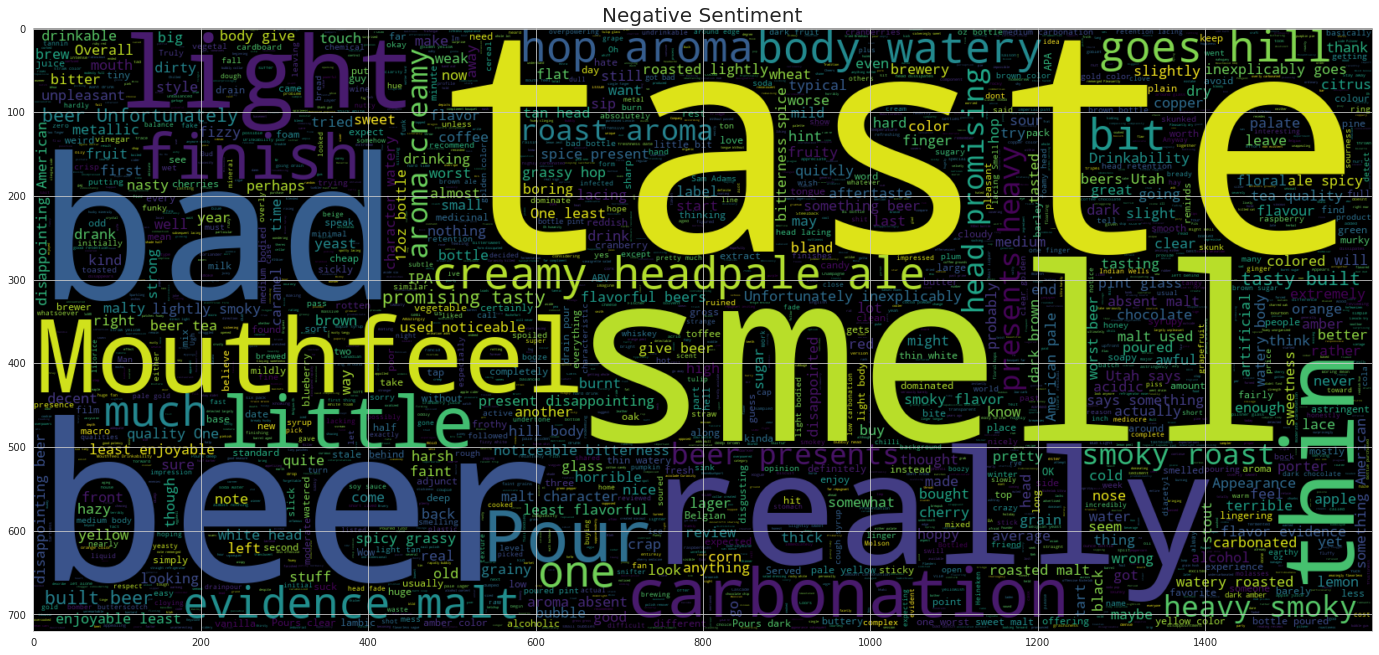

In [251]:
plt.figure(figsize = (24,12)) 
worldcould_neg = WordCloud(min_font_size = 3,  max_words = 3200 , width = 1600 , height = 720).generate(" ".join(negative))
plt.imshow(worldcould_neg,interpolation = 'bilinear')
plt.title("Negative Sentiment", fontsize=20)

Text(0.5, 1.0, 'Neutral Sentiment')

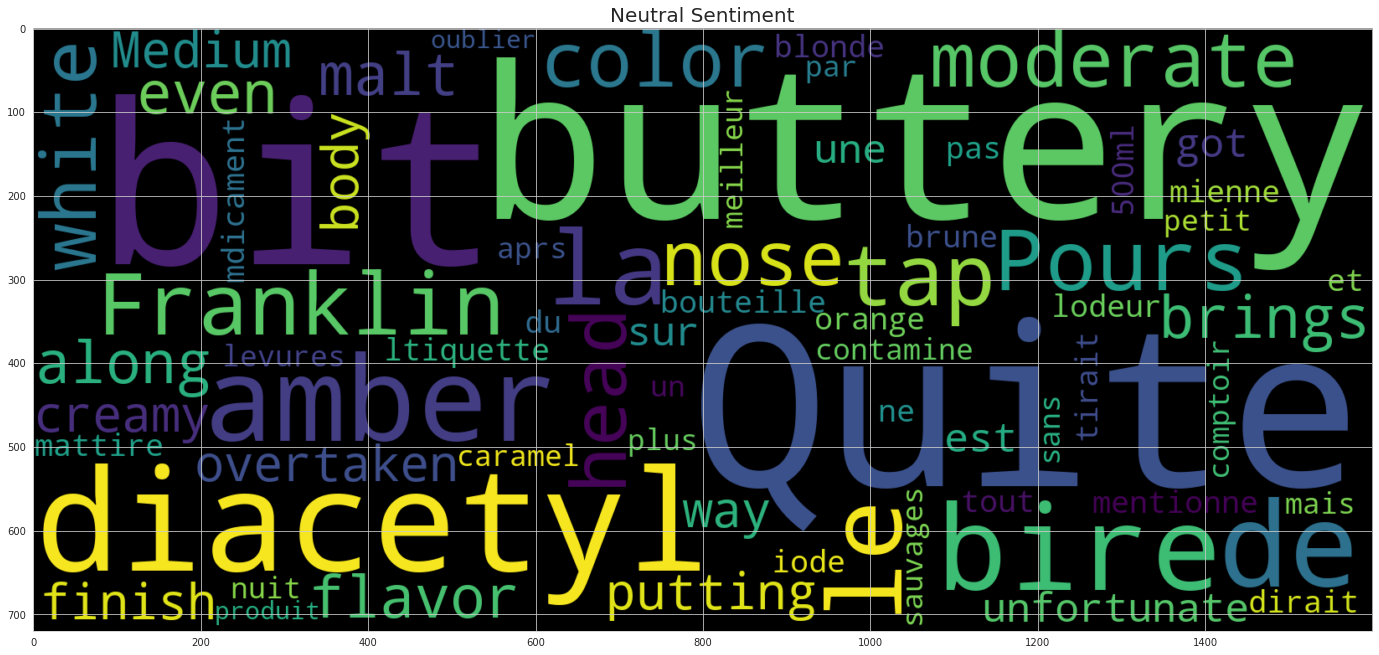

In [252]:
plt.figure(figsize=(24,12))
world_cloud_neutral=WordCloud(min_font_size=3,max_words=3200,width=1600,height=720).generate(" ".join(neutral))
plt.imshow(world_cloud_neutral,interpolation='bilinear')
plt.title("Neutral Sentiment", fontsize=20)

###Sentiment Analysis: Flair Method

In [253]:
!pip install flair

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [254]:
#Let us try using textblob polarity score
df = pd.read_csv('/content/drive/MyDrive/Evolent/BeerDataScienceProject.csv', encoding="ISO-8859-1")

In [255]:
df.columns

Index(['beer_ABV', 'beer_beerId', 'beer_brewerId', 'beer_name', 'beer_style',
       'review_appearance', 'review_palette', 'review_overall', 'review_taste',
       'review_profileName', 'review_aroma', 'review_text', 'review_time'],
      dtype='object')

In [256]:
from flair.models import TextClassifier
from flair.data import Sentence

In [257]:
def flair_prediction(x):
    sentence = Sentence(x)
    sia.predict(sentence)
    score = sentence.labels[0]
    if "POSITIVE" in str(score):
        return "pos"
    elif "NEGATIVE" in str(score):
        return "neg"
    else:
        return "neu"
    
def flair_prediction_value(x):
    sentence = Sentence(x)
    sia.predict(sentence)
    score = sentence.labels[0]
    return score.score

In [258]:
df = df[['beer_beerId','beer_name', 'beer_style','review_overall','review_text']]
df["word_count"] = df['review_text'].str.split().str.len()
df['count'] = 1
df = df[df["word_count"] > 30]
df = df.groupby("review_overall").sample(n=300, random_state=1, replace=True).reset_index()
sia = TextClassifier.load('en-sentiment')
start = time.time()
df["sentiment"] = df["review_text"].apply(flair_prediction)
end = time.time()
print(end - start)

2022-05-30 07:24:27,382 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt
35.35863280296326


In [259]:
df.tail(5)

index  beer_beerId                                beer_name  \
2995  249491         1346                    Chimay Tripel (White)   
2996  515991          576             Samuel Smith's Nut Brown Ale   
2997   93751        30420          Sierra Nevada Torpedo Extra IPA   
2998  388117        24810                               Kodiak IPA   
2999  521222          572  Samuel Smith's, The Famous Taddy Porter   

             beer_style  review_overall  \
2995             Tripel             5.0   
2996  English Brown Ale             5.0   
2997       American IPA             5.0   
2998       American IPA             5.0   
2999     English Porter             5.0   

                                            review_text  word_count  count  \
2995  This is a gold with some cloud to it, nice for...        57.0      1   
2996  poured into pub glass this beer pours a browne...        72.0      1   
2997  My first review. I'm not one to try explain a ...       302.0      1   
2998  Honey colored pour, that is unfiltered and has...        88.0      1   
2999  550ml bottle, capped with gold foil. I can't b...       117.0      1   

     sentiment  
2995       pos  
2996       pos  
2997       neg  
2998       pos  
2999       pos

###Evaluation Metrics

In [260]:
df_grouped = df.groupby(["review_overall", "sentiment"]).sum()
df_grouped

index  beer_beerId  word_count  count
review_overall sentiment                                          
0.0            neg        11885219      1141970     13548.0    300
1.0            neg        77699794      6128206     36962.0    294
               pos         1945394        54258       878.0      6
1.5            neg        78157644      6042418     36763.0    295
               pos          720177       168807       581.0      5
2.0            neg        77531935      5606893     33095.0    276
               pos         6453130       317591      2631.0     24
2.5            neg        68740462      5249212     30609.0    258
               pos        10874026       791180      5011.0     42
3.0            neg        63562062      4619975     24803.0    219
               pos        21726849      1378845      9568.0     81
3.5            neg        38791130      3388274     19292.0    144
               pos        40121061      3514779     17407.0    156
4.0            neg        14568430       904429      6122.0     50
               pos        64036902      6220081     28739.0    250
4.5            neg         9281903       830606      5251.0     36
               pos        70879174      5528826     34537.0    264
5.0            neg         6958202       507497      4446.0     27
               pos        74891948      4703437     37655.0    273

In [261]:
def evaluate_results(df):
    if (5, "pos") in df.index:
        true_positives = df.loc[(5, "pos")]["count"]
    else:
        true_positives = 0
    if (5, "neg") in df.index:
        false_negatives = df.loc[(5, "neg")]["count"]
    else:
        false_negatives = 0
    if (1, "pos") in df.index:
        false_positives = df.loc[(1, "pos")]["count"]
    else:
        false_positives = 0
    if (5, "neg") in df.index:
        true_negatives = df.loc[(1, "neg")]["count"]
    else:
        true_negatives = 0
    accuracy = (true_positives + true_negatives) / (true_positives + false_positives + false_negatives + true_negatives)
    precision = true_positives / (true_positives + false_positives)
    recall = true_positives / (true_positives + false_negatives)
    specificity = true_negatives / (true_negatives + false_positives)
    f1 = 2 * (precision * recall) / (precision + recall)
    print("Accuracy: " + str(accuracy * 100))
    print("Precision: " + str(precision * 100))
    print("Specificity: " + str(specificity * 100))
    print("F1: " + str(f1 * 100))

In [262]:
evaluate_results(df_grouped)

Accuracy: 94.5
Precision: 97.84946236559139
Specificity: 98.0
F1: 94.30051813471503


###Text Visualization

In [263]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=3200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

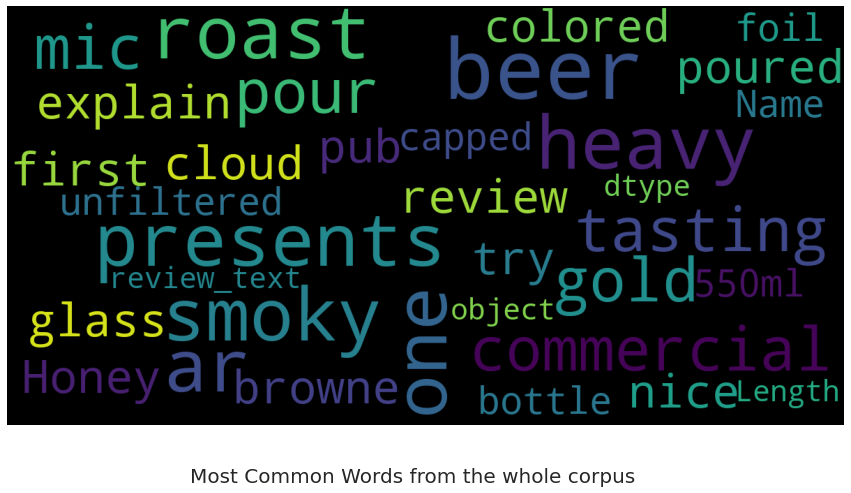

In [264]:
show_wordcloud(df['review_text'],'Most Common Words from the whole corpus')

In [265]:
positive=df[df['sentiment']=='pos'].review_text
negative=df[df['sentiment']=='neg'].review_text
neutral=df[df['sentiment']=='neu'].review_text

Text(0.5, 1.0, 'Positive Sentiment')

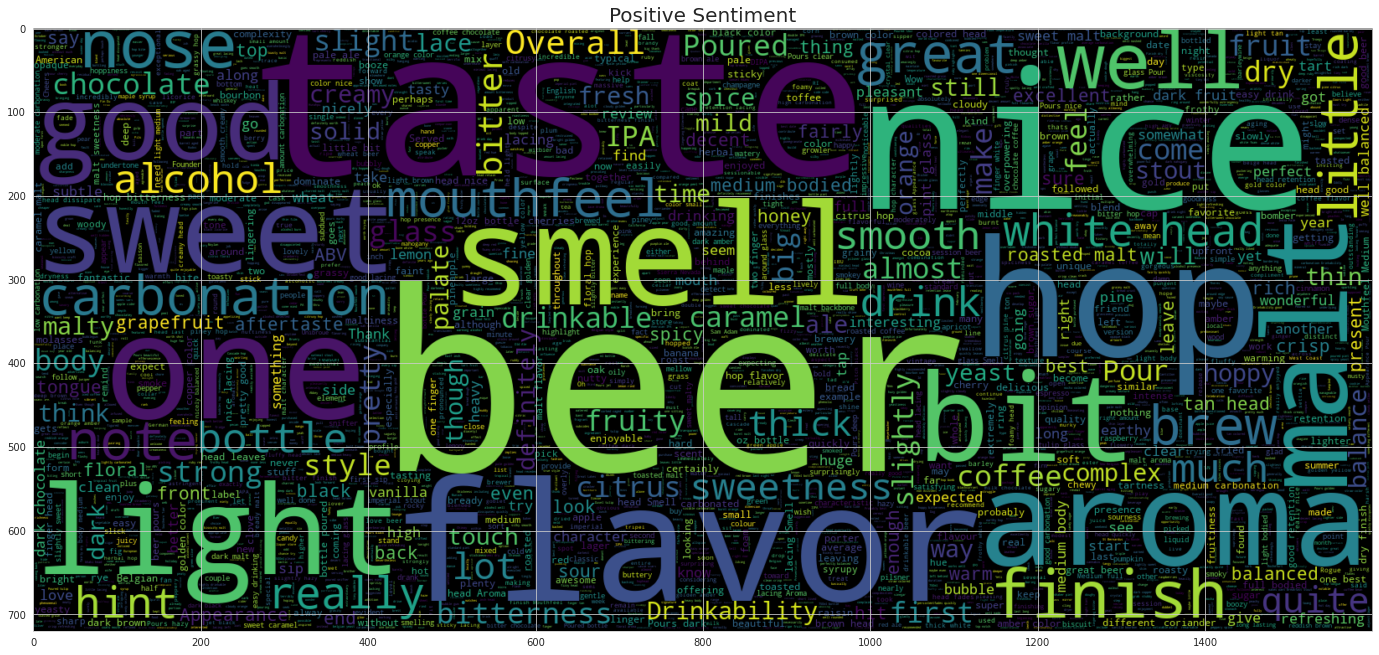

In [266]:
plt.figure(figsize=(24,20))
world_cloud_postive=WordCloud(min_font_size=3,max_words=3200,width=1600,height=720).generate("".join(positive))
plt.imshow(world_cloud_postive,interpolation='bilinear')
plt.title("Positive Sentiment", fontsize=20)

Text(0.5, 1.0, 'Negative Sentiment')

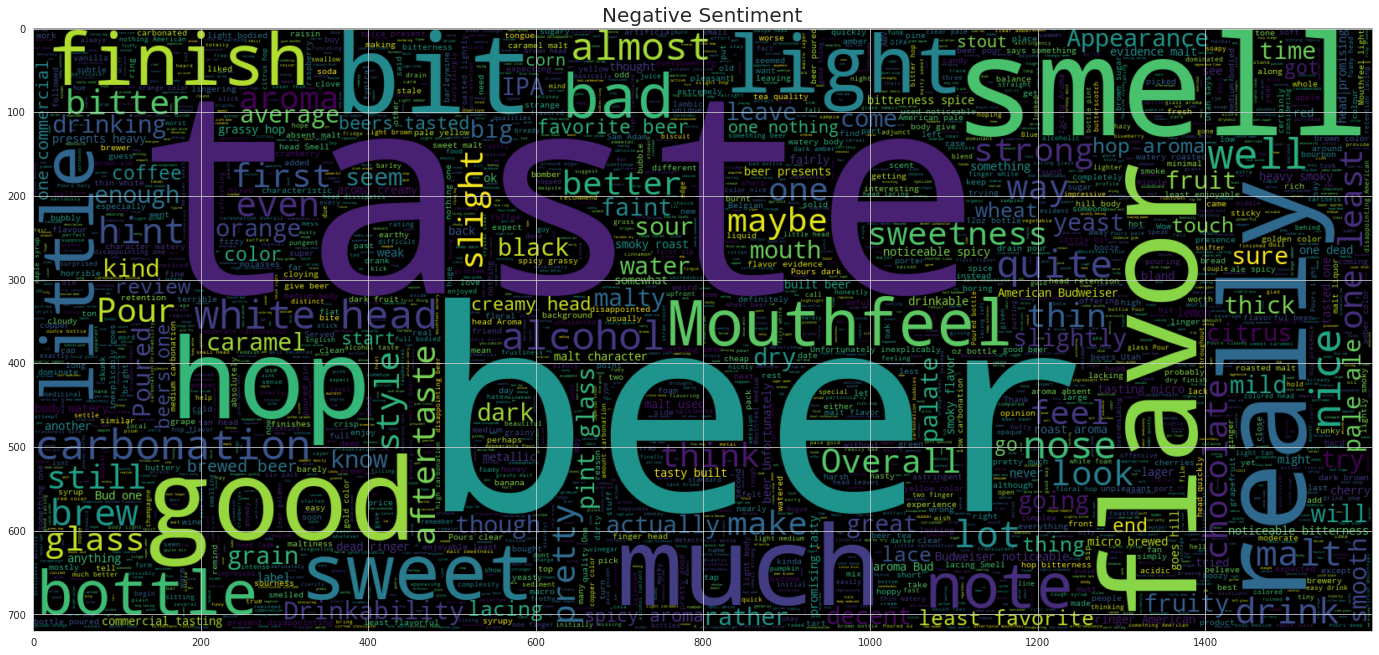

In [267]:
plt.figure(figsize = (24,12)) 
worldcould_neg = WordCloud(min_font_size = 3,  max_words = 3200 , width = 1600 , height = 720).generate(" ".join(negative))
plt.imshow(worldcould_neg,interpolation = 'bilinear')
plt.title("Negative Sentiment", fontsize=20)

In [268]:
# plt.figure(figsize=(24,12))
# world_cloud_neutral=WordCloud(min_font_size=3,max_words=3200,width=1600,height=720).generate(" ".join(neutral))
# plt.imshow(world_cloud_neutral,interpolation='bilinear')
# plt.title("Neutral Sentiment", fontsize=20)

###Answer 6: From above Sentiment Analysis we can get Sentiment for different Overall Review Score for the different Beer Styles

###Question 7: How do find similar Beer Drinkers by using written Reviews Only ?

In [269]:
df.columns

Index(['index', 'beer_beerId', 'beer_name', 'beer_style', 'review_overall',
       'review_text', 'word_count', 'count', 'sentiment'],
      dtype='object')

In [270]:
df.head(5)

index  beer_beerId          beer_name       beer_style  review_overall  \
0  39617         3804  Latter Days Stout  Irish Dry Stout             0.0   
1  39601         3806           Pub Pils   Czech Pilsener             0.0   
2  39601         3806           Pub Pils   Czech Pilsener             0.0   
3  39617         3804  Latter Days Stout  Irish Dry Stout             0.0   
4  39617         3804  Latter Days Stout  Irish Dry Stout             0.0   

                                         review_text  word_count  count  \
0  This beer presents with a heavy smoky roast ar...        53.0      1   
1  This is one of the most commercial tasting mic...        45.0      1   
2  This is one of the most commercial tasting mic...        45.0      1   
3  This beer presents with a heavy smoky roast ar...        53.0      1   
4  This beer presents with a heavy smoky roast ar...        53.0      1   

  sentiment  
0       neg  
1       neg  
2       neg  
3       neg  
4       neg

In [271]:
similar_beer=df[df[['beer_name','review_text','sentiment']].duplicated(keep=False)].sort_values("beer_name")

In [272]:
similar_beer.head(10)

index  beer_beerId            beer_name                beer_style  \
944  279307        29705         Atwater Rost  American Amber / Red Ale   
989  279307        29705         Atwater Rost  American Amber / Red Ale   
585  278721        39884  Atwater Winter Bock                      Bock   
490  278721        39884  Atwater Winter Bock                      Bock   
488  362108         5356  Belle Vue Framboise            Lambic - Fruit   
537  362108         5356  Belle Vue Framboise            Lambic - Fruit   
695  114110         7390  Big Horn Hefeweizen                Hefeweizen   
696  114110         7390  Big Horn Hefeweizen                Hefeweizen   
736  459334        27107           Blonde Ale       American Blonde Ale   
740  459334        27107           Blonde Ale       American Blonde Ale   

     review_overall                                        review_text  \
944             2.0  Poured my beer into a glass and got a great de...   
989             2.0  Poured my beer into a glass and got a great de...   
585             1.0  Well-bodied and glassy ruby red look. One fing...   
490             1.0  Well-bodied and glassy ruby red look. One fing...   
488             1.0  This one was not very impressive to say the le...   
537             1.0  This one was not very impressive to say the le...   
695             1.5  From a sampler at the Indy location: RAM pride...   
696             1.5  From a sampler at the Indy location: RAM pride...   
736             1.5  Thanks to Ryan011235 for this 12 ounce bottle,...   
740             1.5  Thanks to Ryan011235 for this 12 ounce bottle,...   

     word_count  count sentiment  
944       153.0      1       neg  
989       153.0      1       neg  
585        97.0      1       neg  
490        97.0      1       neg  
488       111.0      1       neg  
537       111.0      1       neg  
695       117.0      1       neg  
696       117.0      1       neg  
736       120.0      1       neg  
740       120.0      1       neg

###Answer 7: From above we can find out similar beer drinkers on the basis written reviews